# **KNN for classifiying malicious URLs**


In [7]:
#imports
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from scipy.spatial import KDTree
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

# **Designing KNN Classifier**


In [8]:
#KNN MODEL CLASS

class KNNClassifier:
    def __init__(self, k=3,n_jobs=1):
        self.k = k
        self.data = None
        self.labels = None
        self.tree = None
        self.n_jobs = n_jobs

    def __repr__(self):
        return f"KNNClassifier(k={self.k}, n_jobs={self.n_jobs})"

    def set_params(self, k=None, n_jobs=None):
        if k is not None:
            self.k = k
        if n_jobs is not None:
            self.n_jobs = n_jobs

    def fit(self, x, y):
        x = np.array(x)
        y = np.array(y)
        if x.shape[0] != y.shape[0]:
            raise ValueError("Number of samples in x and y must be equal.")
        self.data = x
        self.labels = y
        self.tree = KDTree(self.data)

    def predict(self, X):
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)  # Ensure X is 2D for a single sample
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            predictions = list(executor.map(self._predict, X))
        return np.array(predictions)

    def _predict(self, x):
        distances, k_indices = self.tree.query([x], k=self.k)
        k_indices = k_indices[0]

        if self.k == 1:
            k_indices = [k_indices]

        k_nearest_labels = [self.labels[i] for i in k_indices]  # labels of k nearest neighbors

        if self.k == 1:
            return k_nearest_labels[0]

        # Prioritize the lowest label in case of a tie
        label_counts = Counter(k_nearest_labels)
        max_count = max(label_counts.values())
        most_common = [label for label, count in label_counts.items() if count == max_count]
        return min(most_common)



# **Data Load From GITHUB Repo**


In [9]:
#LOADING DATA SET

dataset_url = "https://raw.githubusercontent.com/APruner-23/Malicious_URL_Detection/main/updated_malicious_phish_with_tld.csv"
# Read the CSV file from the URL
df = pd.read_csv(dataset_url)

print(df.head())
print(df.shape)


                                                 url        type  url_length  \
0                                   br-icloud.com.br    phishing          16   
1                mp3raid.com/music/krizz_kaliko.html      benign          35   
2                    bopsecrets.org/rexroth/cr/1.htm      benign          31   
3  http://www.garage-pirenne.be/index.php?option=...  defacement          88   
4  http://adventure-nicaragua.net/index.php?optio...  defacement         235   

   hostname_length  path_length  fd_length  tld_dangerosity  count-  count@  \
0                0           16          0              3.0       1       0   
1                0           35          5              3.0       0       0   
2                0           31          7              3.0       0       0   
3               21           10          9              2.0       1       0   
4               23           10          9              3.0       1       0   

   count?  ...  count.  count=  count-http  

# **Class/Labels Dictionary**

In [10]:
class_dictionary = {
    'defacement': 0,
    'phishing': 1,
    'malware': 2,
    'benign': 3,
}

In [11]:
#FEATURE,LABELS EXTRACTION

x = df.iloc[:,2:].values
y = df['type'].map(class_dictionary).values

print("number of attributes: ",x.shape[1])
print("number of samples: ",x.shape[0])
print("number of labels: ",y.shape[0])
print("Unique classes in y:", np.unique(y))

number of attributes:  19
number of samples:  651191
number of labels:  651191
Unique classes in y: [0 1 2 3]


# **Data Split**

In [12]:
#DATA SPLIT

#Initial Split (80% training, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print("Unique classes in y_test :", np.unique(y_test))
print("Unique classes in y_train :", np.unique(y_train))


Unique classes in y_test : [0 1 2 3]
Unique classes in y_train : [0 1 2 3]


# **Grid Search for hyperparameter tuning**

In [ ]:
from sklearn.model_selection import StratifiedKFold

def grid_search_knn(x_train, y_train, k_values, cv=5):
    best_k = None
    best_score = 0
    cv_scores = {}

    #K-Folds cross-validator
    skf = StratifiedKFold(n_splits=cv)

    for k in k_values:
        scores = []
        for train_index, val_index in skf.split(x_train, y_train):
            X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize and train the model
            knn = KNNClassifier(k=k, n_jobs=4)
            knn.fit(X_train_fold, y_train_fold)

            # Predict and evaluate
            y_pred = knn.predict(X_val_fold)
            score = f1_score(y_val_fold, y_pred, average='weighted')
            scores.append(score)

        mean_score = np.mean(scores)
        cv_scores[k] = mean_score

        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    for k, score in cv_scores.items():
        print(f"Average cross-validation score for k={k}: {score}")

    return best_k, best_score

# Test Range of K parameter
k_values = list(range(1, 10))

best_k, best_cv_score = grid_search_knn(x_train, y_train, k_values, cv=5)

print(f"Best k: {best_k}")
print(f"Best cross-validation score: {best_cv_score}")

# Train and evaluate the final model with the best k
best_knn = KNNClassifier(k=best_k, n_jobs=4)
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)


Average cross-validation score for k=1: 0.9357027515988159
Average cross-validation score for k=2: 0.9278458488821041
Average cross-validation score for k=3: 0.9382562406510127
Average cross-validation score for k=4: 0.9357849747517489
Average cross-validation score for k=5: 0.9369882379973126
Average cross-validation score for k=6: 0.9355481856111467
Average cross-validation score for k=7: 0.9349899606039026
Average cross-validation score for k=8: 0.9339801324346901
Average cross-validation score for k=9: 0.9329979090848728
Best k: 3
Best cross-validation score: 0.9382562406510127


# **Evaluation metrics and plots**

Test set F1 score: 0.9401421103240263



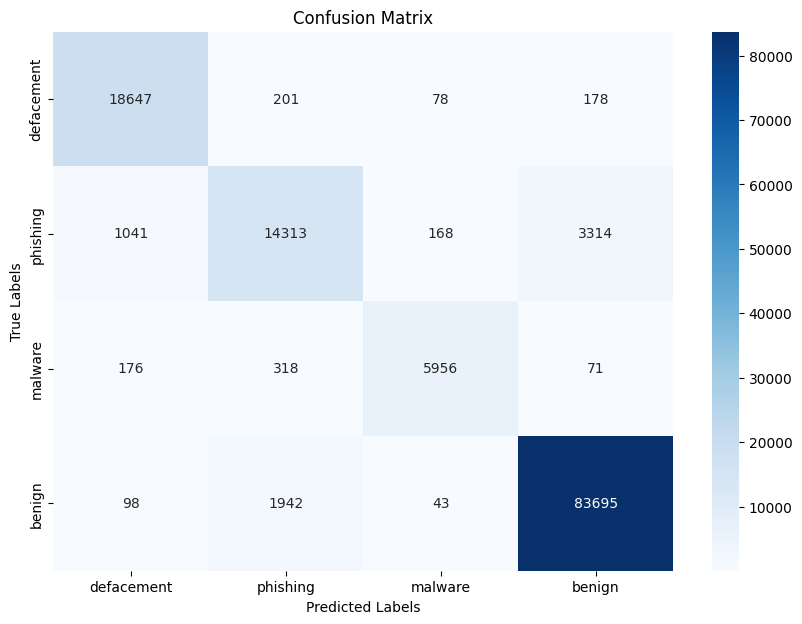

              precision    recall  f1-score   support

  defacement       0.93      0.98      0.95     19104
    phishing       0.85      0.76      0.80     18836
     malware       0.95      0.91      0.93      6521
      benign       0.96      0.98      0.97     85778

    accuracy                           0.94    130239
   macro avg       0.93      0.91      0.91    130239
weighted avg       0.94      0.94      0.94    130239



In [ ]:
#EVALUATION METRICS
test_score = f1_score(y_test, y_pred, average='weighted')
print(f"Test set F1 score: {test_score}")
print("")

#confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_dictionary.keys(), yticklabels=class_dictionary.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#the classification report
report = classification_report(y_test, y_pred, target_names=class_dictionary.keys())
print(report)

# **In the context of classifying URLs to protect users from visiting potentially harmful sites, we can simplify the original multi-class labels into two categories: Benign and Hostile. Benign represents safe URLs, while hostile encompasses all potentially dangerous URLs, including phishing, defacement, and malware. This binary classification allows us to better evaluate the model's effectiveness in distinguishing between safe and harmful URLs, thereby providing a clearer assessment of its protective capabilities. The evaluation metrics for this binary classification are as follows: :**

In [ ]:
#binary class dictionary
class2_dictionary = {
    'Hostile':0,
    'Benign':1,
}

Binary F1 Score: 0.9564674544136937



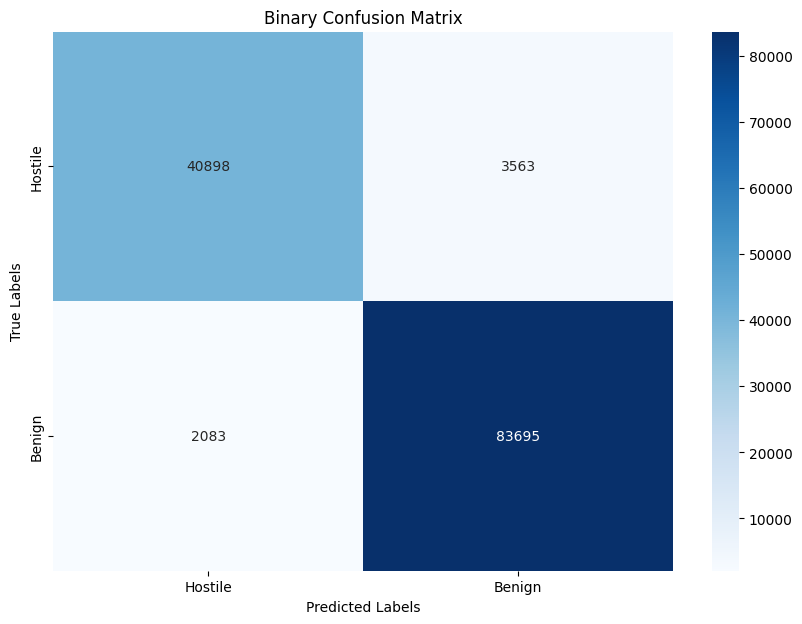

              precision    recall  f1-score   support

     Hostile       0.95      0.92      0.94     44461
      Benign       0.96      0.98      0.97     85778

    accuracy                           0.96    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.96      0.96      0.96    130239



In [ ]:
# Convert labels to binary pattern: 1 for benign (if 3), 0 for hostile (not 3)
binary_y_test = np.where(y_test == 3, 1, 0)
binary_y_pred = np.where(y_pred == 3, 1, 0)

#EVALUATION METRICS
binary_f1_score = f1_score(binary_y_test, binary_y_pred, average='weighted')
print(f'Binary F1 Score: {binary_f1_score}')
print("")

#confusion matrix
binary_confusion_matrix = confusion_matrix(binary_y_test, binary_y_pred)

# Plot of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(binary_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class2_dictionary.keys(), yticklabels=class2_dictionary.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Binary Confusion Matrix')
plt.show()

#the classification report
binary_classification_report = classification_report(binary_y_test, binary_y_pred, target_names=class2_dictionary.keys())
print(binary_classification_report)
